In [11]:
import os
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import glob
import pandas as pd
import numpy as np

from datetime import datetime

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env

from pycaret.regression  import load_model
from pycaret.regression  import predict_model
from pycaret.regression  import *

from sklearn.linear_model import LinearRegression

import random

In [12]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)      

True
11.8


In [13]:
model46800 = load_model('./MODEL/6800_reg')
model48800 = load_model('./MODEL/8800_reg')
model43000 = load_model('./MODEL/43000_reg')


traffic_data = pd.read_csv('./DATA_RL/year_DATA.csv', encoding='cp949')
cond1 = traffic_data['LINK_ID'] == 46800
cond2 = traffic_data['LINK_ID'] == 48800
cond3 = traffic_data['LINK_ID'] == 43000

traffic_data_46800 = traffic_data[cond1]
traffic_data_48800 = traffic_data[cond2]
traffic_data_43000 = traffic_data[cond3]


traffic_data_46800 = traffic_data_46800.T
traffic_data_48800 = traffic_data_48800.T
traffic_data_43000 = traffic_data_43000.T

traffic_data_46800.columns = ['vol']
traffic_data_46800 = traffic_data_46800[0:]
traffic_data_46800 = traffic_data_46800[1:]

traffic_data_48800.columns = ['vol']
traffic_data_48800 = traffic_data_48800[0:]
traffic_data_48800 = traffic_data_48800[1:]

traffic_data_43000.columns = ['vol']
traffic_data_43000 = traffic_data_43000[0:]
traffic_data_43000 = traffic_data_43000[1:]

speed_df_46800 = pd.read_csv('./DATA_RL/1070046800_avg.csv')
# Ensure both DataFrames are aligned by index
traffic_data_46800['speed'] = speed_df_46800['speed'].values

speed_df_48800 = pd.read_csv('./DATA_RL/1070048800_avg.csv')
# Ensure both DataFrames are aligned by index
traffic_data_48800['speed'] = speed_df_48800['speed'].values

speed_df_43000 = pd.read_csv('./DATA_RL/1070043000_avg.csv')
# Ensure both DataFrames are aligned by index
traffic_data_43000['speed'] = speed_df_43000['speed'].values

model_46800, model_48800, model_43000 = LinearRegression(), LinearRegression(), LinearRegression()


X_train_48800 = traffic_data_48800[['speed']].values
y_train_48800 = traffic_data_48800[['vol']].values
# Fit the model to the training data
model_48800.fit(X_train_48800, y_train_48800)
# Fit linear regression models for both traffic IDs


X_train_46800 = traffic_data_46800[['speed']].values
y_train_46800 = traffic_data_46800[['vol']].values
# Fit the model to the training data
model_46800.fit(X_train_46800, y_train_46800)

X_train_43000 = traffic_data_43000[['speed']].values
y_train_43000 = traffic_data_43000[['vol']].values
# Fit the model to the training data
model_43000.fit(X_train_43000, y_train_43000)

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


LinearRegression()

In [14]:
class ROAD(gym.Env):
    def __init__(self, render_mode=None):
        self.ep_num = 0

        self.month = 1
        self.day = 1
        # Initial states of the roads
        self.road46800 = 0
        self.road43000 = 0
        self.road48800 = 0
        self.time_step = 0  # Track time steps

        # Define observation space (state of each road)
        self.observation_space = spaces.Box(low=0, high=200, shape=(3,), dtype=np.float32)

        # Define action space (choose road to prioritize)
        self.action_space = spaces.Discrete(2)
    def step(self, action):
        """
        Takes an action and applies the logic to adjust road traffic.
        """
        if self.time_step <= 120:
            action_46800 = 22
            action_43000 = 5
        elif self.time_step <= 240:
            action_46800 = 26
            action_43000 = 8

        else:
            action_46800 = 28
            action_43000 = 6
    
        
        start_time = pd.Timestamp(f'2024-{self.month:02d}-{self.day:02d} 07:00') + pd.Timedelta(seconds=30 * self.time_step)
        future_dates = pd.DataFrame({'ds': [start_time]})
        future_dates['month'] = future_dates['ds'].dt.month
        future_dates['day'] = future_dates['ds'].dt.day
        future_dates['hour'] = future_dates['ds'].dt.hour
        future_dates['min'] = future_dates['ds'].dt.minute


        df_test = future_dates[['month','day','hour','min']]
        

        # Forecast using the models with sktime-compatible format
        forecast46800_speed = model46800.predict(df_test)
        car_number_46800_hour =  model_46800.predict([forecast46800_speed])
        car_number_46800 = float(car_number_46800_hour/120)

        # Forecast using the models with sktime-compatible format
        forecast43000_speed = model43000.predict(df_test)
        car_number_43000_hour =  model_43000.predict([forecast43000_speed])
        car_number_43000 = float(car_number_43000_hour/120)

        # Update the traffic levels for each road
        self.road46800 += car_number_46800
        self.road43000 += car_number_43000

        # Apply the chosen action to reduce traffic on selected roads
        if action == 0:
            self.road46800 = max(0, self.road46800 - action_46800)
        elif action == 1:
            self.road43000 = max(0, self.road43000 - action_43000)

        # Calculate reward: minimize total traffic on all roads
        reward = -(self.road46800 + self.road43000)

        # Increment time step and check if episode should terminate
        self.time_step += 1
        terminated = self.time_step >= 360  # End episode after 360 steps (3 hours)

        # Get the new observation and info
        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, terminated, False, info

    def reset(self, seed=None, options=None):
        """
        Resets the environment for a new episode.
        """
        super().reset(seed=seed)
        
        self.month = random.randint(1, 12)
        self.day = random.randint(1, 28)
        self.road46800, self.road43000, self.road48800 = 20, 20, 10
        self.time_step = 0

        # Get the initial observation and info
        observation = self._get_obs()
        info = self._get_info()
        self.ep_num += 1

        return observation, info

    def _get_obs(self):
        return np.array([self.road46800, self.road43000, self.time_step], dtype=np.float32)


    def _get_info(self):
        """
        Returns additional information about the environment state.
        """
        return {"time_remaining": 360 - self.time_step}

In [15]:
# Create the environment
env = ROAD()

# Check if the environment is valid
check_env(env, warn=True)

In [16]:
# Create the PPO agent
model = PPO("MlpPolicy", env, verbose=1, device="cuda")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [17]:
import matplotlib.pyplot as plt

In [18]:
# Create the environment
env = ROAD()

# Create the PPO agent
model = PPO("MlpPolicy", env, verbose=1, device="cuda")

# Training the agent
timesteps = 10000
model.learn(total_timesteps=timesteps)

# Test the trained model and record cumulative rewards
num_episodes = 50
rewards_2 = []

for ep in range(num_episodes):
    obs, _ = env.reset()
    done = False
    cum_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        cum_reward += reward
    rewards_2.append(cum_reward)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 360       |
|    ep_rew_mean     | -1.35e+04 |
| time/              |           |
|    fps             | 73        |
|    iterations      | 1         |
|    time_elapsed    | 27        |
|    total_timesteps | 2048      |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 360        |
|    ep_rew_mean          | -1.8e+04   |
| time/                   |            |
|    fps                  | 66         |
|    iterations           | 2          |
|    time_elapsed         | 61         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01599963 |
|    clip_fraction        | 0.0737     |
|    clip_range           | 0.2        |
|    entropy_loss     

In [19]:
total_reward_list = []
for i in range(50):
    month = random.randint(1, 12)
    day = random.randint(1, 28)
    # Initial states of the roads
    road46800 = 0
    road43000 = 0
    road48800 = 0
    time_step = 0  # Track time steps
    action = 0
    total_reward = 0
    while time_step <= 360:

        if time_step <= 120:
            action_46800 = 22
            action_43000 = 5
        elif time_step <= 240:
            action_46800 = 26
            action_43000 = 8

        else:
            action_46800 = 28
            action_43000 = 6

        start_time = pd.Timestamp(f'2024-{month:02d}-{day:02d} 07:00') + pd.Timedelta(seconds=30 * time_step)
        future_dates = pd.DataFrame({'ds': [start_time]})
        future_dates['month'] = future_dates['ds'].dt.month
        future_dates['day'] = future_dates['ds'].dt.day
        future_dates['hour'] = future_dates['ds'].dt.hour
        future_dates['min'] = future_dates['ds'].dt.minute


        df_test = future_dates[['month','day','hour','min']]


        # Forecast using the models with sktime-compatible format
        forecast46800_speed = model46800.predict(df_test)
        car_number_46800_hour =  model_46800.predict([forecast46800_speed])
        car_number_46800 = float(car_number_46800_hour/120)

        # Forecast using the models with sktime-compatible format
        forecast43000_speed = model43000.predict(df_test)
        car_number_43000_hour =  model_43000.predict([forecast43000_speed])
        car_number_43000 = float(car_number_43000_hour/120)
        
        road46800 += car_number_46800
        road43000 += car_number_43000

        # Apply the chosen action to reduce traffic on selected roads
        if action == 0:
            road46800 = max(0, road46800 - action_46800)
        elif action == 1:
            road43000 = max(0, road43000 - action_43000)

        # Calculate reward: minimize total traffic on all roads
        reward = -(road46800 + road43000)
        action +=1
        if action ==2:
            action = 0

        total_reward +=reward
        time_step+=1

    total_reward_list.append(total_reward)



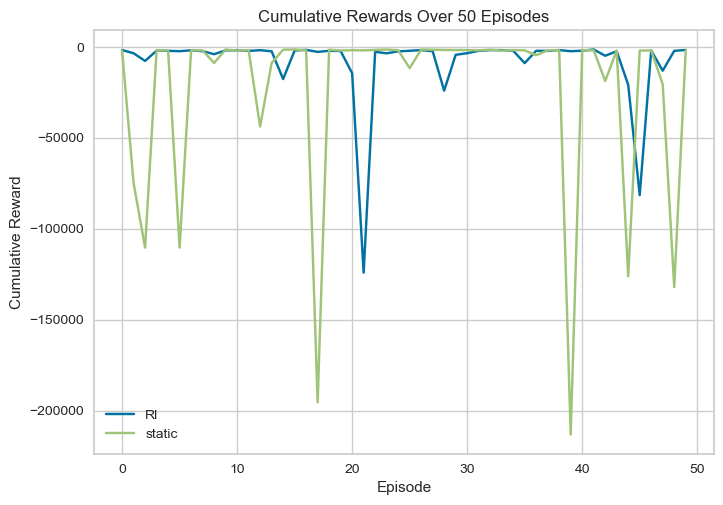

In [20]:
# Plotting cumulative rewards for different scenarios
plt.plot(rewards_2, label='Rl')
plt.plot(total_reward_list, label='static')
# Adding title and labels
plt.title(f"Cumulative Rewards Over {num_episodes} Episodes")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")

# Adding a legend to distinguish between different reward sets
plt.legend(loc='lower left')
# Display the plot
plt.show()
